In [1]:
from bfiw_reg.registrar import BFIWReg
import cv2
import numpy as np
import os
import imageio
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import re

In [2]:
import re

bfi_regex = re.compile(r'B_244-ST_BFI-SE_(\d+).jpg')
bfiw_regex = re.compile(r'B_244-ST_BFIW-SE_(\d+).jpg')

In [3]:
bfi_path = '244_BFIW/BFI'
bfiw_path = '244_BFIW/BFIW'

bfi = {bfi_regex.match(f).group(1).zfill(4): imageio.imread_v2(os.path.join(bfi_path, f)) for f in tqdm(os.listdir(bfi_path)) if f.endswith('.jpg')}
bfiw = {bfiw_regex.match(f).group(1).zfill(4): imageio.imread_v2(os.path.join(bfiw_path, f)) for f in tqdm(os.listdir(bfiw_path)) if f.endswith('.jpg')} 

100%|██████████| 2496/2496 [02:42<00:00, 15.33it/s]


In [ ]:
(np.median(sample_bfi_gray)/np.median(sample_bfiw_gray))

In [ ]:
sample_bfi = bfi['1202']
sample_bfiw = bfiw['1202']

sample_bfi_gray = cv2.cvtColor(sample_bfi, cv2.COLOR_RGB2GRAY)
sample_bfiw_gray = cv2.cvtColor(sample_bfiw, cv2.COLOR_RGB2GRAY)

plt.imshow(sample_bfiw_gray - sample_bfi_gray, cmap='gray')
plt.axis('off')


In [9]:
reg = BFIWReg(src_dir='244_BFIW/BFIW', dest_dir='244_BFIW_reg/BFIW',ref_idx='1608', regex= re.compile(r'B_244-ST_BFIW-SE_(\d+).jpg'))

In [ ]:
reg.register()

In [ ]:
reg.save_output()

In [215]:
retinex_imgs = [slide.msr_img for slide in reg.slides.values()]

In [216]:
ret_imgs = retinex_imgs[::130]

In [ ]:
# fig, ax = plt.subplots(len(ret_imgs), 3, figsize=(30, 30))

# for i, img in enumerate(ret_imgs):
#     for j in range(3):
#         img_ = img[:,:,j]
#         ax[i][j].imshow(img_, cmap='gray')
#         ax[i][j].axis('off')
#         ax[i][j].set_title(f'Image {i}:Channel {j}')
# plt.show()
fig, ax = plt.subplots(len(ret_imgs), 1, figsize=(30, 30))
for i, img in enumerate(ret_imgs):
    img__ = np.abs(np.mean(img[:,:,:], axis=2)-img[:,:,1])
    img__[img__>2]=255
    ax[i].imshow(img__, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Image {i}:Channel 2-1')
    # ret_imgs[i] = 255-np.abs(np.mean(img[:,:,1:], axis=2)-img[:,:,0])




In [78]:
# Sort BFI

bfi = dict(sorted(bfi.items(), key=lambda x: x[0]))
bfiw = dict(sorted(bfiw.items(), key=lambda x: x[0]))


In [ ]:
plt.imshow(bfiw['1202'])

In [ ]:
# sigmoid


In [88]:
eps = np.finfo(np.float32).eps

In [ ]:
img_bfiw = bfiw['1202'].copy()
img_bfi = bfi['1202'].copy()
darkfield = bfi['2677'].copy()
brightfield = bfiw['2677'].copy()
# img_bfiw = cv2.cvtColor(img_bfiw, cv2.COLOR_RGB2LAB)
# img_bfi = cv2.cvtColor(img_bfi, cv2.COLOR_RGB2LAB)

Corrected_Image = ((img_bfiw - darkfield) / (brightfield - darkfield + eps)) * 255
Corrected_Image = (Corrected_Image - np.min(Corrected_Image))/ (np.max(Corrected_Image) - np.min(Corrected_Image))


channel_id = 2
# img_bfiw_channel = np.std(img_bfiw[:,:,:].copy(), axis=-1)
# img_bfiw_channel = np.std(img_bfiw[:,:,channel_id].copy(), axis=-1)
img_bfiw_channel = img_bfiw[:,:,channel_id].copy()
img_bfi_channel =  img_bfi[:,:,channel_id].copy()
# img_bfi_channel = np.std(img_bfi[:,:,channel_id].copy(), axis=-1)
# img_bfi_channel = np.std(img_bfi[:,:,:].copy(), axis=-1)

img_bfiw_channel = -np.log10((img_bfiw_channel+eps)/np.max(img_bfiw_channel))
img_bfi_channel = -np.log10((img_bfi_channel+eps)/np.max(img_bfi_channel))

img_bfiw_channel[img_bfiw_channel<0] = 0
img_bfi_channel[img_bfi_channel<0] = 0

img_bfi_channel = (img_bfi_channel - np.min(img_bfi_channel))/ (np.max(img_bfi_channel) - np.min(img_bfi_channel))
img_bfiw_channel = (img_bfiw_channel - np.min(img_bfiw_channel))/ (np.max(img_bfiw_channel) - np.min(img_bfiw_channel))
fig, ax = plt.subplots(1, 4, figsize=(40, 40))
ax[0].imshow(img_bfiw_channel, cmap='gray')
ax[0].axis('off')
ax[0].set_title(f'BFIW {np.min(img_bfiw_channel)} { np.max(img_bfiw_channel)}')
ax[1].imshow(img_bfi_channel, cmap='gray')
ax[1].axis('off')
ax[1].set_title(f'BFI {np.min(img_bfi_channel)} { np.max(img_bfi_channel)}')
ax[2].imshow(img_bfi_channel/img_bfiw_channel, cmap='gray')
ax[2].axis('off')
ax[2].set_title(f'BFI* BFIW {np.min(img_bfi_channel)} { np.max(img_bfi_channel)}')
ax[3].imshow(img_bfiw - darkfield, cmap='gray')
ax[3].axis('off')
ax[3].set_title(f'Corrected Image {np.min(Corrected_Image)} { np.max(Corrected_Image)}')
plt.show()



In [ ]:
# plt.imshow( np.max(3*img_bfiw - 2*img_bfi, axis=-1))

def convert_RGB_to_OD(I):
    """
    Convert from RGB to optical density (OD_RGB) space.

    RGB = 255 * exp(-1*OD_RGB).

    :param I: Image RGB uint8.
    :return: Optical denisty RGB image.
    """
    mask = (I == 0)
    I[mask] = 1
    return np.maximum(-1 * np.log(I / 255), 1e-6)


img_bfiw_gray = cv2.cvtColor(img_bfiw, cv2.COLOR_RGB2GRAY)
img_bfiw_gray = img_bfiw[:,:,0]
img_bfi_gray = cv2.cvtColor(img_bfi, cv2.COLOR_RGB2GRAY)

def background_removal_dog(brightfield_img, kernel1=15, kernel2=25):
    """Remove background using the Difference of Gaussian (DoG) method."""
    # Apply Gaussian blur with two different kernel sizes
    blurred1 = cv2.GaussianBlur(brightfield_img, (kernel1, kernel1), 0)
    blurred2 = cv2.GaussianBlur(brightfield_img, (kernel2, kernel2), 0)
    
    # Subtract the two blurred images (Difference of Gaussians)
    dog_result = blurred1 - blurred2
    
    # Threshold to isolate the foreground
    _, binarized_foreground = cv2.threshold(dog_result, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_TRIANGLE)
    
    return binarized_foreground

bg = background_removal_dog(img_bfiw_gray, kernel1=23, kernel2=45)

plt.imshow(convert_RGB_to_OD(img_bfiw_gray), cmap='gray')
# np.percentile(255 - np.mean(img_bfiw - brightfield, axis=-1), np.linspace(0,100,11))

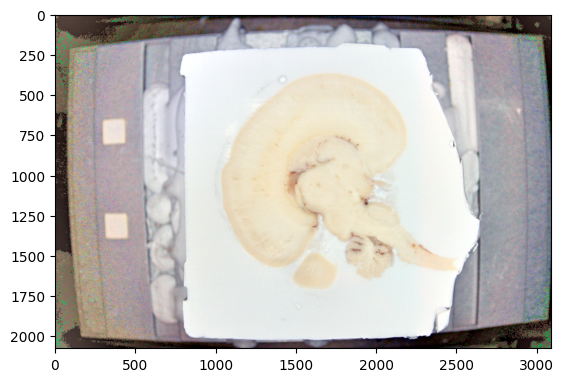

In [4]:
from bfiw_reg.retinex import msrcr

img_bfiw = bfiw['1202'].copy()
img_bfi = bfi['1202'].copy()

img_bfi_retinex = msrcr(img_bfi)
img_bfiw_retinex = msrcr(img_bfiw)

plt.imshow(img_bfi_retinex, alpha=0.3)
plt.imshow(img_bfiw_retinex)

In [14]:
import skimage.filters
import skimage.restoration
import skimage.util

# hess_img = skimage.filters.hessian(img_bfiw_retinex)
roll_ball_img = skimage.restoration.rolling_ball(skimage.util.invert(np.mean(img_bfiw,axis=-1)), radius=50)

In [17]:
import h5py

In [26]:
import h5py

filename = "/storage/valis_reg/segmentation_masks/0717_msrcr_Simple Segmentation.h5"

def read_h5_mask(filename):
    with h5py.File(filename, "r") as f:
        data = f['exported_data']
        data = np.squeeze(np.array(data), axis=-1)
    return data


mask = read_h5_mask(filename)

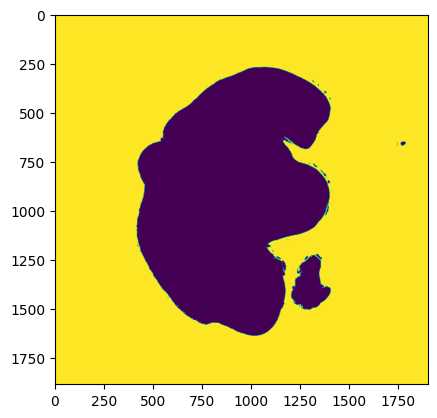

In [27]:
plt.imshow(mask)

## Read all the Cropped Retinex and Cropped Original Images

In [29]:
retinex_imgs = {f.split('_')[0]: imageio.imread_v2(os.path.join('/storage/valis_reg/244_BFIW_reg/BFIW/msrcr', f)) for f in tqdm(sorted(os.listdir('/storage/valis_reg/244_BFIW_reg/BFIW/msrcr')))}
orig_imgs = {f.split('.')[0]: imageio.imread_v2(os.path.join('/storage/valis_reg/244_BFIW_reg/BFIW/original', f)) for f in tqdm(sorted(os.listdir('/storage/valis_reg/244_BFIW_reg/BFIW/original')))}

100%|██████████| 2496/2496 [01:52<00:00, 22.24it/s]


In [30]:
segmentation_dir = '/storage/valis_reg/segmentation_masks'
segmentation_masks = {f.split('_')[0]: read_h5_mask(os.path.join(segmentation_dir, f)) for f in tqdm(sorted(os.listdir(segmentation_dir)))}

100%|██████████| 1747/1747 [00:06<00:00, 271.20it/s]


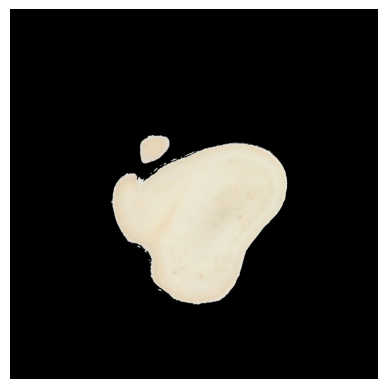

In [70]:
slide_idx = '0349'

masked_out = cv2.bitwise_and(retinex_imgs[slide_idx].copy(), retinex_imgs[slide_idx].copy(), mask=((1-segmentation_masks[slide_idx])==0).astype(np.uint8))
# masked_out = cv2.cvtColor(masked_out, cv2.COLOR_RGB2GRAY)
# masked_out[masked_out==0] = 255
plt.imshow(masked_out)
plt.axis('off')
plt.show()

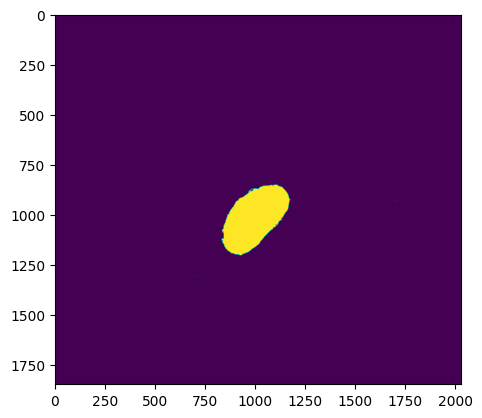

In [54]:
plt.imshow(((1-segmentation_masks['0022'])==0).astype(np.uint8))

Text(0.5, 1.0, 'Segmentation Mask 0 255')

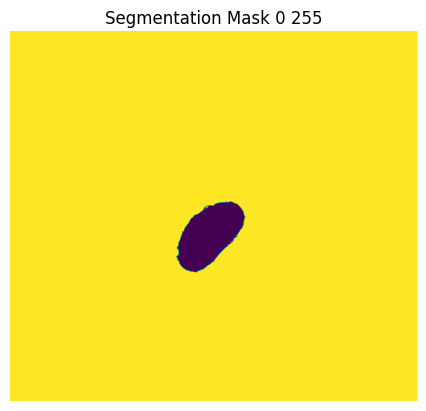

In [51]:
plt.imshow((1-segmentation_masks['0022']))
plt.axis('off')
plt.title(f'Segmentation Mask {np.min(1-segmentation_masks["0022"])} {np.max(1-segmentation_masks["0022"])}')